# TP Integrador Aprendizaje Automático I

### Librerías

In [113]:
import pandas as pd
import numpy as np
import seaborn as sns
import nbimporter
from funciones import *
from geopy.distance import geodesic
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import folium

### Carga de datos y exploración

In [114]:
### Carga datos de dataset
### Contiene aproximadamente 10 años de observaciones diarias de variables climáticas: temperatura, dirección y velocidad del viento, humedad, presión, nubosidad, y cantidad de lluvia en mm.
### tras observar los datos del día de hoy, el objetivo es predecir las variables target:
###                                                                                     -RainFallTomorrow: cantidad de lluvia del día posterior a la observación. Problema de Regresión.
###                                                                                     -RainTomorrow: si el día siguiente llueve o no llueve. Problema de Clasificación.
file_path= 'weatherAUS.csv'
df = pd.read_csv(file_path, sep=',',engine='python')

In [115]:
### Vista de datos
df.head()

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,0.0
1,1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,0.0
2,2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,0.0
3,3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,1.0
4,4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,0.2


In [116]:
# Se elimina la primer columna con el índice
df = df.drop('Unnamed: 0', axis=1)

In [117]:
# Se analizan los tipos de datos que conforman el dataset
print(df.dtypes)

Date                 object
Location             object
MinTemp             float64
MaxTemp             float64
Rainfall            float64
Evaporation         float64
Sunshine            float64
WindGustDir          object
WindGustSpeed       float64
WindDir9am           object
WindDir3pm           object
WindSpeed9am        float64
WindSpeed3pm        float64
Humidity9am         float64
Humidity3pm         float64
Pressure9am         float64
Pressure3pm         float64
Cloud9am            float64
Cloud3pm            float64
Temp9am             float64
Temp3pm             float64
RainToday            object
RainTomorrow         object
RainfallTomorrow    float64
dtype: object


In [118]:
# Se convierte la columna 'Date' de string (object) a datetime
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# Se toma como fecha base la mínima fecha del df
fecha_base = df['Date'].min()

# Se calcula el número de días desde la fecha base
df['Date'] = (df['Date'] - fecha_base).dt.days


In [119]:
#Se reemplaza 'Yes' por 1 y 'No' por 0 en las columnas RainToday y RainTomorrow
# errors='coerce' permite conservar los nan aún cambiando el tipo de datos a booleano
df['RainToday'] = pd.to_numeric(df['RainToday'].replace({'Yes': 1, 'No': 0}), errors='coerce').astype('boolean')
df['RainTomorrow'] = pd.to_numeric(df['RainTomorrow'].replace({'Yes': 1, 'No': 0}), errors='coerce').astype('boolean')

C:\Users\julia\AppData\Local\Temp\ipykernel_16948\84528137.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['RainToday'] = pd.to_numeric(df['RainToday'].replace({'Yes': 1, 'No': 0}), errors='coerce').astype('boolean')
C:\Users\julia\AppData\Local\Temp\ipykernel_16948\84528137.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['RainTomorrow'] = pd.to_numeric(df['RainTomorrow'].replace({'Yes': 1, 'No': 0}), errors='coerce').astype('boolean')


In [120]:
#Se mapean las direcciones dadas ('SSW', 'S', 'SE', etc.) a números del 0 al 15 según las agujas del reloj
directions_mapping = {
    'N': 0,
    'NNE': 1,
    'NE': 2,
    'ENE': 3,
    'E': 4,
    'ESE': 5,
    'SE': 6,
    'SSE': 7,
    'S': 8,
    'SSW': 9,
    'SW': 10,
    'WSW': 11,
    'W': 12,
    'WNW': 13,
    'NW': 14,
    'NNW': 15
}

In [121]:
# Se reemplaza en df los nuevos valores
df['WindGustDir'] = df['WindGustDir'].replace(directions_mapping)
df['WindDir9am'] = df['WindDir9am'].replace(directions_mapping)
df['WindDir3pm'] = df['WindDir3pm'].replace(directions_mapping)

C:\Users\julia\AppData\Local\Temp\ipykernel_16948\216544107.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['WindGustDir'] = df['WindGustDir'].replace(directions_mapping)
C:\Users\julia\AppData\Local\Temp\ipykernel_16948\216544107.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['WindDir9am'] = df['WindDir9am'].replace(directions_mapping)
C:\Users\julia\AppData\Local\Temp\ipykernel_16948\216544107.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain th

In [122]:
#Se conserva el df original para las 49 ciudades
df_49=df

# Lista de ubicaciones permitidas
allowed_locations = ['Adelaide', 'Canberra', 'Cobar', 'Dartmoor', 'Melbourne', 'MelbourneAirport', 'MountGambier', 'Sydney', 'SydneyAirport']

# Eliminar las demás ubicaciones del DataFrame original
df = df[df['Location'].isin(allowed_locations)]

In [123]:
df.describe()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainfallTomorrow
count,28233.000000,27663.000000,27675.000000,27247.000000,23880.000000,21520.000000,26588.000000,26591.000000,26585.000000,27796.000000,...,27893.000000,27293.000000,27343.000000,27394.000000,27404.000000,18866.000000,18683.000000,27648.000000,27657.000000,27248.000000
mean,1913.110367,11.263319,21.902078,2.050369,4.826499,6.891129,7.711110,41.835471,7.376378,8.048928,...,20.023052,68.766350,50.497385,1018.249325,1016.149624,4.668557,4.732805,15.477127,20.408345,2.049347
std,948.862211,5.709936,6.693168,6.384560,3.707995,3.867622,4.694183,14.186300,5.054644,4.503144,...,8.979409,18.730306,19.944931,7.423776,7.267376,2.807571,2.628154,5.701031,6.532302,6.383931
min,0.000000,-8.000000,4.100000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,...,0.000000,5.000000,1.000000,982.300000,984.900000,0.000000,0.000000,-1.300000,3.700000,0.000000
25%,1082.000000,7.400000,16.600000,0.000000,2.200000,3.800000,4.000000,31.000000,2.000000,4.000000,...,13.000000,57.000000,37.000000,1013.300000,1011.300000,1.000000,2.000000,11.400000,15.400000,0.000000
50%,1955.000000,10.900000,21.000000,0.000000,4.000000,7.400000,8.000000,39.000000,8.000000,8.000000,...,19.000000,70.000000,50.000000,1018.400000,1016.300000,6.000000,6.000000,15.000000,19.500000,0.000000
75%,2739.000000,15.200000,26.200000,1.000000,6.600000,10.000000,12.000000,50.000000,12.000000,12.000000,...,26.000000,83.000000,64.000000,1023.300000,1021.100000,7.000000,7.000000,19.125000,24.500000,1.000000
max,3523.000000,33.900000,46.800000,119.400000,86.200000,14.300000,15.000000,122.000000,15.000000,15.000000,...,76.000000,100.000000,100.000000,1040.600000,1037.900000,9.000000,8.000000,38.600000,46.100000,119.400000


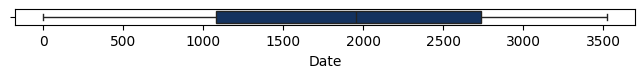

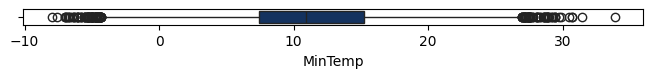

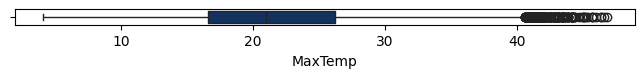

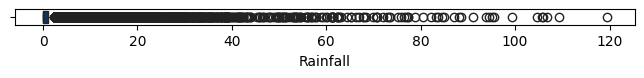

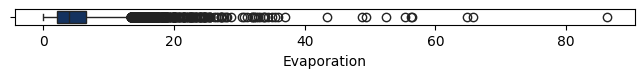

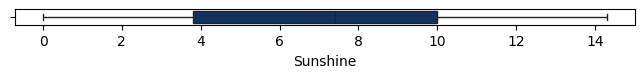

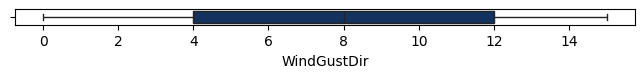

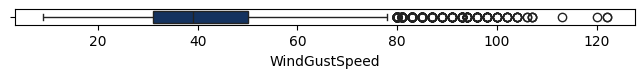

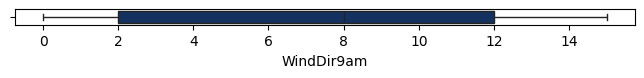

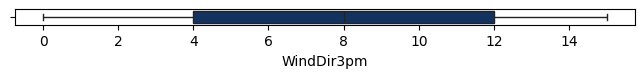

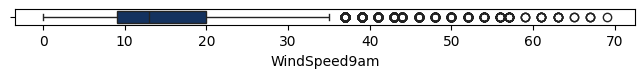

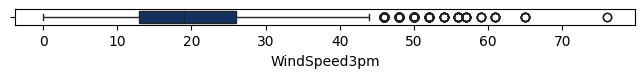

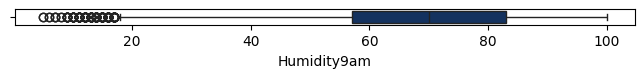

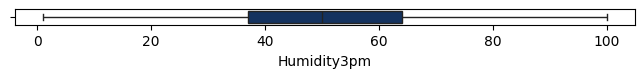

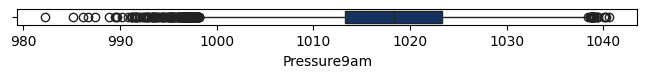

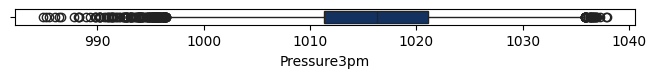

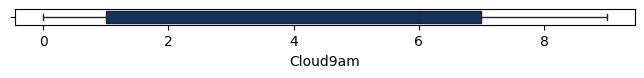

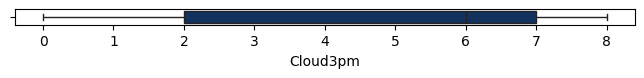

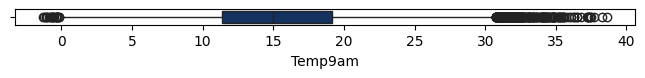

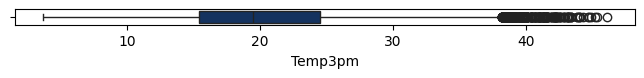

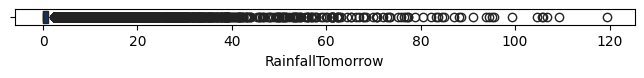

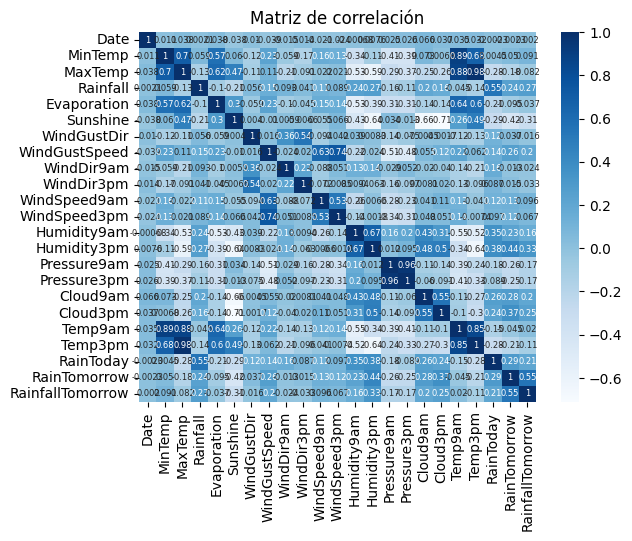

In [124]:
explorar(df)

### Partición del Dataframe

In [125]:
# Se chequea que todas las fechas tengan un valor
df['Date'].isna().sum()

0

Se particiona el df en df_train y df_test en una proporción aproximada de 80% 20%, correspondiendo los del df_train a los datos cronológicamente más antiguos.

In [126]:
# Ordenamiento por la columna 'Date'
df = df.sort_values('Date')

# Calcular el índice que corresponde al 80% del DataFrame
index_at_80_percent = int(len(df) * 0.8)

# Usar el índice para obtener la fecha en ese punto
date_at_80_percent = df.iloc[index_at_80_percent]['Date']

# Crear df_train y df_test basado en esta fecha
df_train = df[df['Date'] <= date_at_80_percent]
df_test = df[df['Date'] > date_at_80_percent]

# Mostrar el número de registros en cada conjunto
print(f"Entrenamiento: {len(df_train)} registros")
print(f"Prueba: {len(df_test)} registros")
print(f"Suma de registro Entrenamiento y Prueba: {len(df_test)+len(df_train)} registros")
print(f"Cantidad total de registros en df original: {df.shape[0]} registros")


Entrenamiento: 22590 registros
Prueba: 5643 registros
Suma de registro Entrenamiento y Prueba: 28233 registros
Cantidad total de registros en df original: 28233 registros


### Análisis de valores nulos

#### Primeros análisis

Se cuenta la cantidad de filas con al menos un valor nan. Dicho valor debe ser menor al 5% del total de registros. Se observa que el segundo valor supera al primero, por lo que deberá analizarse el tratamiento a dar a los valores nan para su reemplazo.

Observación: todo el análisis se hará sobre el df_train.

In [127]:
print(f'Número máximo de filas para eliminar: {int(0.05 * df_train.shape[0])}')

Número máximo de filas para eliminar: 1129


In [128]:
# Contar filas que contienen al menos un valor NaN
nan_rows_count = df_train.isna().any(axis=1).sum()

# Imprimir el resultado
print(f'Número de filas con al menos un valor NaN: {nan_rows_count}')


Número de filas con al menos un valor NaN: 11516


In [129]:
### Cantidad de valores faltantes.
df_train.isna().sum().sort_values(ascending=False)

Cloud3pm            7469
Cloud9am            7179
Sunshine            3962
Evaporation         2016
WindGustDir         1571
WindGustSpeed       1568
WindDir9am          1415
RainfallTomorrow     742
Rainfall             742
RainToday            742
RainTomorrow         742
Pressure9am          625
Pressure3pm          618
Humidity9am          605
Humidity3pm          561
WindDir3pm           414
Temp9am              372
Temp3pm              366
MinTemp              357
WindSpeed9am         350
MaxTemp              344
WindSpeed3pm         336
Location               0
Date                   0
dtype: int64

Se analiza a continuación cada variable, con su variable más correlacionada, y la cantidad de nulos de cada una:

In [130]:
analisis_nan(df_train)

g:\Mi unidad\TUIA\IA4.1 AA I\Trabajo Práctico Integrador\AA1-TUIA-Garcia-Herrera\funciones.py:117: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_nan = pd.concat([df_nan, pd.DataFrame({'Columna': [columna],


,Columna,Max_Abs_Correlacion,Valor_Correlacion,Valores_NaN
0,Date,Pressure3pm,0.072729,0
1,MinTemp,Temp9am,0.892961,357
2,MaxTemp,Temp3pm,0.982767,344
3,Rainfall,RainToday,0.550871,742
4,Evaporation,Temp9am,0.652501,2016
5,Sunshine,Cloud3pm,-0.708560,3962
6,WindGustDir,WindDir3pm,0.545980,1571
7,WindGustSpeed,WindSpeed3pm,0.742479,1568
8,WindDir9am,WindGustDir,0.368278,1415
9,WindDir3pm,WindGustDir,0.545980,414


In [131]:
# Se reemplazan los nan con la siguiente función, para las variables más correlacionadas
recrear_nan(df_train,'MinTemp','Temp9am')
analisis_nan(df_train)

g:\Mi unidad\TUIA\IA4.1 AA I\Trabajo Práctico Integrador\AA1-TUIA-Garcia-Herrera\funciones.py:117: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_nan = pd.concat([df_nan, pd.DataFrame({'Columna': [columna],


,Columna,Max_Abs_Correlacion,Valor_Correlacion,Valores_NaN
0,Date,Pressure3pm,0.072729,0
1,MinTemp,Temp9am,0.892996,347
2,MaxTemp,Temp3pm,0.982767,344
3,Rainfall,RainToday,0.550871,742
4,Evaporation,Temp9am,0.652501,2016
5,Sunshine,Cloud3pm,-0.708560,3962
6,WindGustDir,WindDir3pm,0.545980,1571
7,WindGustSpeed,WindSpeed3pm,0.742479,1568
8,WindDir9am,WindGustDir,0.368278,1415
9,WindDir3pm,WindGustDir,0.545980,414


Se observa que la mayoría de las variables no presenta una fuerte correlación con las demás, por lo que no resulta válido reconstruir los valores nulos mediante regresión lineal.
Es por eso que se hace a continuación un análisis más detallado para estas variables.

#### Matriz de distancias geodésicas

Se construye una matriz con las distancias entre todas las ciudades del df original, que ayudará a comprender la posibilidad de adoptar valores de ciudades aledañas:

In [132]:
# Coordenadas de las ciudades
cities_coords_9 = {
    'Adelaide': (-34.9285, 138.6007),
    'Canberra': (-35.2809, 149.1300),
    'Cobar': (-31.4983, 145.8344),
    'Dartmoor': (-37.9225, 141.2760),
    'Melbourne': (-37.8136, 144.9631),
    'MelbourneAirport': (-37.6690, 144.8410),
    'MountGambier': (-37.8284, 140.7804),
    'Sydney': (-33.8688, 151.2093),
    'SydneyAirport': (-33.9399, 151.1753)
}

cities_coords = {
    'Adelaide': (-34.9285, 138.6007),
    'Albany': (-35.0228, 117.8814),
    'AliceSprings': (-23.6980, 133.8807),
    'Albury': (-36.0737, 146.9135),
    'BadgerysCreek': (-33.8817, 150.7440),
    'Ballarat': (-37.5622, 143.8503),
    'Bendigo': (-36.7570, 144.2784),
    'Brisbane': (-27.4698, 153.0251),
    'Cairns': (-16.9186, 145.7781),
    'Canberra': (-35.2809, 149.1300),
    'Cobar': (-31.4983, 145.8344),
    'CoffsHarbour': (-30.2963, 153.1157),
    'Darwin': (-12.4634, 130.8456),
    'Dartmoor': (-37.9225, 141.2760),
    'GoldCoast': (-28.0167, 153.4000),
    'Hobart': (-42.8821, 147.3272),
    'Katherine': (-14.4646, 132.2635),
    'Launceston': (-41.4341, 147.1374),
    'Melbourne': (-37.8136, 144.9631),
    'MelbourneAirport': (-37.6690, 144.8410),
    'Mildura': (-34.1847, 142.1625),
    'Moree': (-29.4658, 149.8407),
    'MountGambier': (-37.8284, 140.7804),
    'MountGinini': (-35.5294, 148.7744),
    'Newcastle': (-32.9272, 151.7765),
    'Nhil': (-36.3348, 141.6503),
    'NorahHead': (-33.2821, 151.5671),
    'NorfolkIsland': (-29.0408, 167.9547),
    'Nuriootpa': (-34.4694, 138.9939),
    'Penrith': (-33.7511, 150.6942),
    'Perth': (-31.9505, 115.8605),
    'PerthAirport': (-31.9403, 115.9672),
    'PearceRAAF': (-31.6736, 116.0174),
    'Portland': (-38.3463, 141.6042),
    'Richmond': (-33.5995, 150.7391),
    'Sale': (-38.1118, 147.0680),
    'SalmonGums': (-32.9815, 121.6438),
    'Sydney': (-33.8688, 151.2093),
    'SydneyAirport': (-33.9399, 151.1753),
    'Townsville': (-19.2580, 146.8169),
    'Tuggeranong': (-35.4244, 149.0888),
    'Uluru': (-25.3455, 131.0369),
    'WaggaWagga': (-35.1082, 147.3598),
    'Walpole': (-34.9777, 116.7338),
    'Watsonia': (-37.7110, 145.0830),
    'Williamtown': (-32.8150, 151.8428),
    'Witchcliffe': (-34.0261, 115.1003),
    'Wollongong': (-34.4278, 150.8931),
    'Woomera': (-31.1994, 136.8253)
}

# Crear un DataFrame vacío
dist_matrix = pd.DataFrame(index=cities_coords.keys(), columns=cities_coords.keys())

# Calcular las distancias y llenar la matriz
for city1 in cities_coords:
    for city2 in cities_coords:
        dist = geodesic(cities_coords[city1], cities_coords[city2]).kilometers
        dist_matrix.at[city1, city2] = round(dist, 2)

# Mostrar la matriz de distancias
print(dist_matrix)


                 Adelaide   Albany AliceSprings   Albury BadgerysCreek  \
Adelaide              0.0   1888.6      1326.08   764.58       1121.82   
Albany             1888.6      0.0      1992.48  2625.31       3008.83   
AliceSprings      1326.08  1992.48          0.0  1858.21       1991.62   
Albury             764.58  2625.31      1858.21      0.0        425.94   
BadgerysCreek     1121.82  3008.83      1991.62   425.94           0.0   
Ballarat           554.88   2342.2       1807.3   319.32        745.19   
Bendigo            551.48  2383.56      1757.34   248.19        668.67   
Brisbane           1601.7   3431.8      1966.04   1115.3        743.63   
Cairns            2119.21  3418.42      1450.56  2125.39       1943.74   
Canberra           960.32  2835.57      1953.86   219.08        214.52   
Cobar              773.97  2625.02      1461.11   517.23        530.79   
CoffsHarbour      1454.23  3329.19      2040.92   862.77        456.25   
Darwin            2608.53  2820.24    

In [133]:
# Crear un mapa centrado en Australia
mapa = folium.Map(location=[-25.2744, 133.7751], zoom_start=4)

# Añadir marcadores para cada ciudad en el diccionario
for city, coords in cities_coords.items():
    folium.Marker(location=coords, popup=city).add_to(mapa)

# Guardar el mapa en un archivo HTML
mapa.save('mapa_ciudades.html')


#### Análisis nan por distancias

Se crea la función general procesar_geo_nan, que permite analizar y reemplazar los datos nulos por aquellos del mismo día para ciudades vecinas, con un radio de km a definir.

Luego, se hace un análisis pormenorizado de los demás valores nulos, reemplazando con datos de ciudades más lejanas pero en donde se observa una buena correlación de los datos, utilizando gráficos de dispersión para comparar entre ciudades.

In [134]:
df_train_cleared = procesar_geo_nan(df_train, df_49, dist_matrix, cities_coords, 250)

Procesando las siguientes columnas: ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday']
El rango fijado para ciudades cercanas es (km): 250
Analizando la variable: MinTemp
Resultado del análisis geográfico:
     Location  MinTemp NaN Count   Nearest City Distance (km)
0  Melbourne                273       Watsonia         15.53
1   Dartmoor                 64   MountGambier         44.84
2   Canberra                  4    Tuggeranong         16.36
3      Cobar                  3     WaggaWagga        424.81
4     Sydney                  2  SydneyAirport          8.49
5   Adelaide                  1      Nuriootpa         62.38
Procesando la localidad: Melbourne
Intentando con la ciudad más cercana Watsonia a 15.53 km.


La cantidad de datos reemplazados fue 273
Todos los NaNs fueron reemplazados para Melbourne en la variable MinTemp.
Procesando la localidad: Dartmoor
Intentando con la ciudad más cercana MountGambier a 44.84 km.
La cantidad de datos reemplazados fue 64
Todos los NaNs fueron reemplazados para Dartmoor en la variable MinTemp.
Procesando la localidad: Canberra
Intentando con la ciudad más cercana Tuggeranong a 16.36 km.
La cantidad de datos reemplazados fue 4
Todos los NaNs fueron reemplazados para Canberra en la variable MinTemp.
Procesando la localidad: Sydney
Intentando con la ciudad más cercana SydneyAirport a 8.49 km.
La cantidad de datos reemplazados fue 2
Todos los NaNs fueron reemplazados para Sydney en la variable MinTemp.
Procesando la localidad: Adelaide
Intentando con la ciudad más cercana Nuriootpa a 62.38 km.
La cantidad de datos reemplazados fue 0
Analizando la variable: MaxTemp
Resultado del análisis geográfico:
     Location  MaxTemp NaN Count   Nearest City Distance (km)

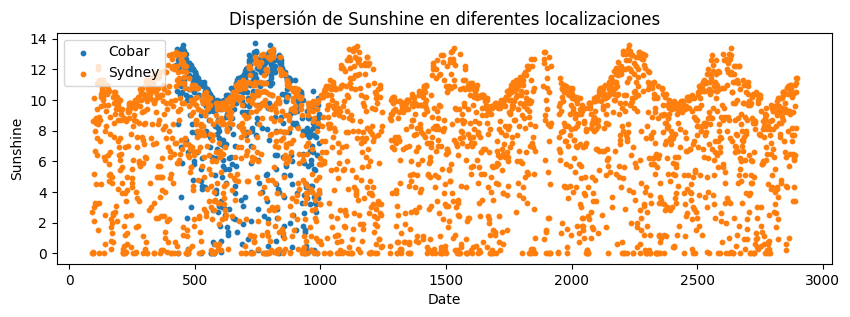

,Location,Sunshine NaN Count,Nearest City,Distance (km)
0,Cobar,1831,WaggaWagga,424.81
1,Adelaide,39,Nuriootpa,62.38
2,MountGambier,14,Dartmoor,44.84
3,Dartmoor,14,MountGambier,44.84
4,Sydney,2,SydneyAirport,8.49
5,SydneyAirport,2,Sydney,8.49


In [135]:
variable='Sunshine'
location='Cobar'
location_near='Sydney'
graf_dispersion_comparativa(df_train_cleared, [location, location_near], 'Date',variable)
analisis_geo_nan(df_train_cleared, variable, dist_matrix, cities_coords)

In [136]:
df_train_cleared = recrear_geo_nan(df_train_cleared,df_49,'Cobar','Sydney','Sunshine')

La cantidad de datos reemplazados fue 1826


In [137]:
# Crear una copia del DataFrame sin las columnas 'RainfallTomorrow' y 'RainTomorrow'
df_filtered = df_train_cleared.drop(columns=['RainTomorrow','RainfallTomorrow'])

# Contar filas que contienen al menos un valor NaN en el DataFrame filtrado
nan_rows_count_filtered = df_filtered.isna().any(axis=1).sum()
print(f'Número de filas con al menos un valor NaN (sin contar RainTomorrow y RainfallTomorrow): {nan_rows_count_filtered}')

Número de filas con al menos un valor NaN (sin contar RainTomorrow y RainfallTomorrow): 783


In [138]:
df_train_cleared=df_train_cleared.dropna()
nan_rows_count_filtered = df_train_cleared.isna().any(axis=1).sum()
print(f'Número de filas con al menos un valor NaN (sin contar RainTomorrow y RainfallTomorrow): {nan_rows_count_filtered}')

Número de filas con al menos un valor NaN (sin contar RainTomorrow y RainfallTomorrow): 0
